# ISSR Predictions - Does the presence of an ISSR in one location predict the presence of an ISSR in another location?

## Imports

In [246]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
import keras_tuner as kt
from joblib import Parallel, delayed
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier

## Buffalo Dataset 2010 - 2024

In [155]:
#Load in the ISSR Dataset that covers 2010-2024
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo, NY_issr2010_2024.csv")

In [200]:
#Filter to 2010 and 2023. This will be used for training and testing
df = data[(data['year'] >= 2010) & (data['year'] <= 2023) & (data['press'] != -9999)]

In [201]:
#Convert categoricals into numerics to feed into our machine learning models
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [202]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
temp_count = df[df['temp_f'] < -42].groupby(df['date'].dt.date).size()
rh_ice_count = df[df['rh_ice'] > 1].groupby(df['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'issc_buffalo'
temp_count.name = 'temp_volume_buffalo'
rh_ice_count.name = 'rhi_volume_buffalo'

df2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df3 = pd.merge(df2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df = pd.merge(df3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)

In [203]:
#Make ISSC_Buffalo binary 0 or 1 instances each day. 
new_df.loc[new_df['issc_buffalo'] > 0, 'issc_buffalo'] = 1

## Upton Dataset 2010 - 2024

In [204]:
#Load in Upton ISSR dataset
data_upton = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Upton, NY_issr2010_2024.csv")

In [211]:
#Filter to 2010 and 2023. This will be used for training and testing
df_upton = data_upton[(data_upton['year'] >= 2010) & (data_upton['year'] <= 2023) & (data_upton['press'] != -9999)]

In [212]:
#Convert categoricals into numerics to feed into our machine learning models
warnings.filterwarnings("ignore")
df_upton['issc'] = df_upton['issc'].replace({'yes': 1, 'no': 0})

In [213]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df_upton['date'] = pd.to_datetime(df_upton['date'])
issc_counts_per_day = df_upton[df_upton['issc'] == 1].groupby(df_upton['date'].dt.date).size()
temp_count = df_upton[df_upton['temp_f'] < -42].groupby(df_upton['date'].dt.date).size()
rh_ice_count = df_upton[df_upton['rh_ice'] > 1].groupby(df_upton['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df_upton['date'].min(), end=df_upton['date'].max(), freq='D'))
issc_counts_per_day.name = 'issc_upton'
temp_count.name = 'temp_volume_upton'
rh_ice_count.name = 'rhi_volume_upton'

df_upton2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df_upton3 = pd.merge(df_upton2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df_upton = pd.merge(df_upton3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)

In [214]:
#Make ISSC Upton binary 0 or 1 instances each day. 
new_df_upton.loc[new_df_upton['issc_upton'] > 0, 'issc_upton'] = 1

## Combine Buffalo and Upton Datasets

In [215]:
#Do a join on the date index for both datasets
combined_df = new_df.join(new_df_upton)

In [217]:
#Create Ceiling and Floors for each day for Buffalo
max_ceiling = df.groupby(df['date'])['ceiling'].max()
max_floor = df.groupby(df['date'])['floor'].max()

combined_df = combined_df.join(max_ceiling)
combined_df = combined_df.join(max_floor)
combined_df.rename(columns = {'ceiling': 'ceiling_buf', 'floor': 'floor_buf'}, inplace = True)

In [218]:
#Create Ceiling and Floors for each day for Upton
max_ceiling_upton = df_upton.groupby(df_upton['date'])['ceiling'].max()
max_floor_upton = df_upton.groupby(df_upton['date'])['floor'].max()

combined_df = combined_df.join(max_ceiling_upton)
combined_df = combined_df.join(max_floor_upton)
combined_df.rename(columns = {'ceiling': 'ceiling_upton', 'floor': 'floor_upton'}, inplace = True)

In [220]:
#If an instance of ceiling or floor is 0, make it equal it's corresponding ceiling or floor value. 
for index, row in combined_df.iterrows():
    if row['ceiling_buf'] == 0:
        combined_df.at[index, 'ceiling_buf'] = row['floor_buf']
    if row['floor_buf'] == 0:
        combined_df.at[index, 'floor_buf'] = row['ceiling_buf']
    if row['ceiling_upton'] == 0:
        combined_df.at[index, 'ceiling_upton'] = row['floor_upton']
    if row['floor_upton'] == 0:
        combined_df.at[index, 'floor_upton'] = row['ceiling_upton']

In [221]:
#Create vertical depth variables
combined_df['vertical_depth_buf'] = combined_df['ceiling_buf'] - combined_df['floor_buf']
combined_df['vertical_depth_upton'] = combined_df['ceiling_upton'] - combined_df['floor_upton']

In [222]:
#Fill in 0 for all NA values. If NA's are not filled in, we can not feed the data into machine learning models.
combined_df.fillna(0, inplace = True)

In [223]:
#Final dataset to be fed into our models
combined_df

,issc_buffalo,temp_volume_buffalo,rhi_volume_buffalo,issc_upton,temp_volume_upton,rhi_volume_upton,ceiling_buf,floor_buf,ceiling_upton,floor_upton,vertical_depth_buf,vertical_depth_upton
2010-01-01,0.0,29.0,0.0,0.0,31.0,3.0,0.00,0.00,0.00,0.00,0.00,0.0
2010-01-02,0.0,39.0,2.0,0.0,34.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
2010-01-03,0.0,42.0,2.0,0.0,37.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
2010-01-04,0.0,35.0,11.0,0.0,42.0,4.0,0.00,0.00,0.00,0.00,0.00,0.0
2010-01-05,0.0,29.0,5.0,0.0,28.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,71.0,1.0,0.0,39.0,0.0,30248.73,30248.73,0.00,0.00,0.00,0.0
2023-12-28,0.0,51.0,2.0,1.0,32.0,14.0,0.00,0.00,29010.95,29010.95,0.00,0.0
2023-12-29,0.0,61.0,6.0,0.0,45.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
2023-12-30,1.0,81.0,25.0,0.0,33.0,0.0,29166.97,28099.86,0.00,0.00,1067.11,0.0


## Correlation between Buffalo and Upton

In [224]:
#Want to look a a small portion of the overall correlation plot
combined_df[['issc_buffalo', 'issc_upton', 'vertical_depth_buf', 'vertical_depth_upton']].corr()

,issc_buffalo,issc_upton,vertical_depth_buf,vertical_depth_upton
issc_buffalo,1.000000,0.088311,0.454526,0.148990
issc_upton,0.088311,1.000000,0.057386,0.401581
vertical_depth_buf,0.454526,0.057386,1.000000,0.062583
vertical_depth_upton,0.148990,0.401581,0.062583,1.000000


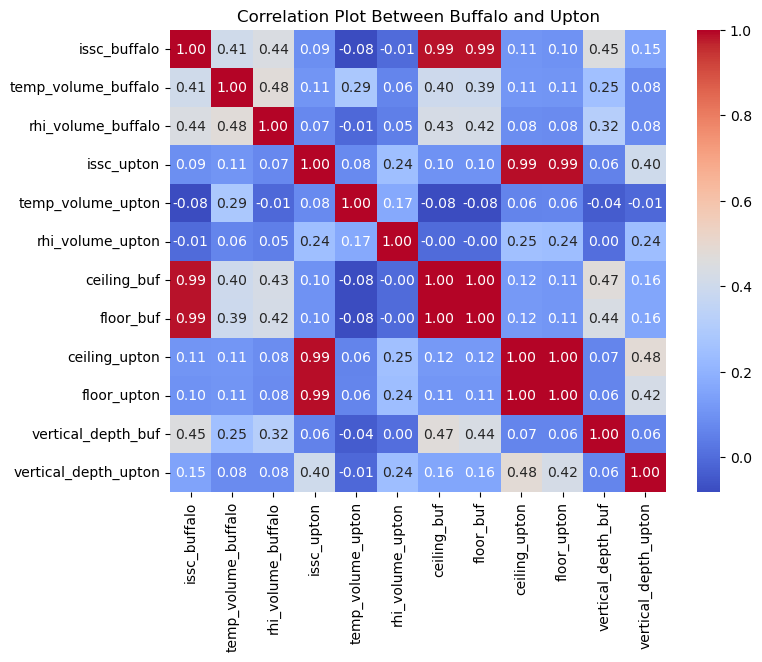

In [225]:
#Plot the entire correlation plot between Buffalo and Upton
plt.figure(figsize = (8,6))
sns.heatmap(combined_df.corr(), annot =True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Plot Between Buffalo and Upton')
plt.show()

## Logisitc Regression for Classiciation

In [226]:
#Was asked to see how predictive an ISSR in one site and it's vertical depth can predict an instance of an ISSR at the other site.
X = combined_df[['issc_buffalo', 'vertical_depth_buf']]
y = combined_df['issc_upton']

In [227]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [228]:
#Assign model as logisitic regression
model = LogisticRegression()

In [229]:
#Fit the x and y training variables into the logisitic regression model
model.fit(X_train, y_train)

LogisticRegression()

In [230]:
#Test the predictive power of the model
y_pred = model.predict(X_test)

In [231]:
#Print accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9843597262952102


In [232]:
#Model statistics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1007
         1.0       0.00      0.00      0.00        16

    accuracy                           0.98      1023
   macro avg       0.49      0.50      0.50      1023
weighted avg       0.97      0.98      0.98      1023



In [233]:
#Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1007,    0],
       [  16,    0]], dtype=int64)

## Undersampling for Logisitc Regression

In [234]:
#Resample the dataset using under sampling techniques
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)

In [235]:
#Train/ Test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [236]:
#Fit new data to logisitic regression model
model.fit(X_train2, y_train2)

LogisticRegression()

In [237]:
#Make predictions
y_pred2 = model.predict(X_test2)

In [238]:
#Print out accuracy
accuracy2 = accuracy_score(y_test2, y_pred2)
print(accuracy2)

0.6136363636363636


In [239]:
#Print out confusion matrix
confusion_matrix(y_test2, y_pred2)

array([[22,  0],
       [17,  5]], dtype=int64)

## Oversampling for Logisitic Regression

In [240]:
#Resample the dataset using over sampling techniques
X_resampled_over, y_resampled_over = RandomOverSampler().fit_resample(X, y)

In [241]:
#Train/test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_resampled_over, y_resampled_over, test_size = 0.2, random_state = 42)

In [242]:
#Fit new data to logisitic regression model
model.fit(X_train3, y_train3)

LogisticRegression()

In [243]:
#make predictions
y_pred3 = model.predict(X_test3)

In [244]:
#Print accuracy
accuracy3 = accuracy_score(y_test3, y_pred3)
print(accuracy3)

0.5694305694305695


In [245]:
#Print out confusion matrix
confusion_matrix(y_test3, y_pred3)

array([[986,  30],
       [832, 154]], dtype=int64)

## Random Forest Classifier for Classification

In [ ]:
#See if Random Forest has better predictive ability
rf_model = RandomForestClassifier(n_estimators = 100, random_state =42)
rf_model.fit(X_train, y_train)

In [249]:
#Create predictions
y_pred_rf = rf_model.predict(X_test)

In [250]:
#Print Accuracy
accuracy_score(y_test, y_pred_rf)

0.9794721407624634

## Random Forest Classifier with Oversampled Dataset

In [251]:
#Try Random Forest with Oversampled Dataset
rf_model.fit(X_train3, y_train3)

RandomForestClassifier(random_state=42)

In [254]:
#Create Predictions
y_pred_rf3 = rf_model.predict(X_test3)

In [255]:
#Print accuracy
accuracy_score(y_test3, y_pred_rf3)

0.5749250749250749

## Neural Network for Classification using Oversampled Dataset

In [256]:
#Try building a neural network to see it's predictive capability
model = Sequential()

In [259]:
#Input layer
model.add(Dense(units = 64, activation = 'relu', input_dim = X_train3.shape[1]))
#Hidden layer
model.add(Dense(units = 32, activation = 'relu'))
#Output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [260]:
#Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [263]:
#Fit oversampled data to neural network model
model.fit(X_train3, y_train3, epochs = 100, batch_size = 32, validation_data = (X_test3, y_test3))

Epoch 1/100
251/251 [==============================] - 2s 3ms/step - loss: 1.1495 - accuracy: 0.5479 - val_loss: 0.9791 - val_accuracy: 0.5694
Epoch 2/100
251/251 [==============================] - 1s 2ms/step - loss: 0.9226 - accuracy: 0.5533 - val_loss: 1.4796 - val_accuracy: 0.5385
Epoch 3/100
251/251 [==============================] - 1s 2ms/step - loss: 0.8753 - accuracy: 0.5501 - val_loss: 1.0239 - val_accuracy: 0.5694
Epoch 4/100
251/251 [==============================] - 1s 2ms/step - loss: 0.9713 - accuracy: 0.5431 - val_loss: 0.8550 - val_accuracy: 0.5694
Epoch 5/100
251/251 [==============================] - 1s 2ms/step - loss: 0.8808 - accuracy: 0.5513 - val_loss: 1.1173 - val_accuracy: 0.5385
Epoch 6/100
251/251 [==============================] - 1s 2ms/step - loss: 0.8213 - accuracy: 0.5515 - val_loss: 0.6958 - val_accuracy: 0.5704
Epoch 7/100
251/251 [==============================] - 1s 3ms/step - loss: 1.0290 - accuracy: 0.5503 - val_loss: 1.0588 - val_accuracy: 0.5694

In [277]:
#Create predictions with neural network. Create a threshold of 0.5
y_pred_nn = model.predict(X_test3)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_nn]

63/63 [==============================] - 0s 1ms/step


In [278]:
#Print accuracy
accuracy_score(y_test3, y_pred_binary)

0.5704295704295704

In [279]:
#Print confusion matrix
confusion_matrix(y_test3, y_pred_binary)

array([[988,  28],
       [832, 154]], dtype=int64)